In [27]:
import sys,os
import torch

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.VariableEncoder.datasets.dataset import CustomDataset

def get_normal_dataset(air_variable, surface_variable, year_offset: int, tgt_time_len: int):
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    weather = WeatherDataset(year_offset, device=device)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    source, label, mean_std = weather.load(air_variable + surface_variable)

    dataset = CustomDataset(source, label, tgt_time_len)
    return (WeatherDataset.HAS_LEVEL_VARIABLE, WeatherDataset.NONE_LEVEL_VARIABLE, WeatherDataset.PRESSURE_LEVELS), dataset, source.shape, mean_std, label.size(-1)



dataset_info, dataset, shape, mean_std, out_dim = get_normal_dataset(,0, 24)

TypeError: get_normal_dataset() missing 1 required positional argument: 'tgt_time_len'

In [23]:
import numpy as np
import pandas as pd

import xarray_beam as xbeam

ds, chunk = xbeam.open_zarr('gcs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2')
print(chunk)

LEVEL = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]

lat_min, lat_max = (32, 39.3)
lon_min, lon_max = (124, 131.4)

lat_indices = np.where((ds.latitude >= lat_min) & (ds.latitude <= lat_max))[0]
lon_indices = np.where((ds.longitude >= lon_min) & (ds.longitude <= lon_max))[0]

print(lat_indices)

start_date = pd.to_datetime('2016-12-31')
end_date = pd.to_datetime('2021-12-31')
source_dataset2 = ds.sel(time=slice(start_date, end_date)).sel(level=LEVEL).isel(latitude=lat_indices, longitude=lon_indices).sortby('latitude', ascending=True)

print(source_dataset2)

{'time': 1, 'latitude': 721, 'longitude': 1440, 'level': 37}
[203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232]
<xarray.Dataset>
Dimensions:                                           (time: 43825,
                                                       latitude: 30,
                                                       longitude: 30, level: 13)
Coordinates:
  * latitude                                          (latitude) float32 32.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float32 124...
  * time                                              (time) datetime64[ns] 2...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 ...
    2m_temperature               

In [24]:
print(source_dataset1.shape)

torch.Size([43825, 6, 1300])


In [25]:
source_dataset2 = source_dataset2.isel(time=1301)
source_dataset2 = source_dataset2['2m_temperature'].values
print(source_dataset2.flatten())

[279.66754 279.7431  279.85004 279.97266 280.13235 280.36194 280.62714
 280.94366 281.18323 281.42847 281.6395  281.93036 282.13568 282.3396
 282.54776 282.69177 282.80725 282.9085  282.97693 283.014   283.07248
 283.10526 283.18796 283.168   283.1951  283.04254 282.73596 282.81296
 283.40326 285.07864 279.40518 279.50357 279.61765 279.75735 279.93845
 280.168   280.43607 280.74692 280.995   281.14615 281.35004 281.56107
 281.77353 281.94034 282.07864 282.20984 282.37094 282.42798 282.5164
 282.59195 282.65042 282.68323 282.72742 282.7089  283.1395  282.51923
 282.639   281.20602 281.73074 283.81677 279.2013  279.3125  279.45508
 279.61194 279.79587 280.0183  280.2892  280.49454 280.63568 280.7626
 280.93512 281.13046 281.38284 281.5468  281.68225 281.79776 281.9375
 281.98456 282.0416  282.11002 282.18988 282.26544 282.23834 282.04727
 282.45364 283.995   282.7089  280.66992 279.6818  281.0492  279.0473
 279.15994 279.30536 279.48645 279.6661  279.85574 280.0297  280.14664
 280.2992  

In [18]:
torch.set_printoptions(threshold=10_000)
print(source_dataset1[1301][0])

tensor([279.6675, 279.7431, 279.8500, 279.9727, 280.1324, 280.3619, 280.6271,
        280.9437, 281.1832, 281.4285, 281.6395, 281.9304, 282.1357, 282.3396,
        282.5478, 282.6918, 282.8073, 282.9085, 282.9769, 283.0140, 283.0725,
        283.1053, 283.1880, 283.1680, 283.1951, 283.0425, 282.7360, 282.8130,
        283.4033, 285.0786, 279.4052, 279.5036, 279.6176, 279.7574, 279.9384,
        280.1680, 280.4361, 280.7469, 280.9950, 281.1461, 281.3500, 281.5611,
        281.7735, 281.9403, 282.0786, 282.2098, 282.3709, 282.4280, 282.5164,
        282.5919, 282.6504, 282.6832, 282.7274, 282.7089, 283.1395, 282.5192,
        282.6390, 281.2060, 281.7307, 283.8168, 279.2013, 279.3125, 279.4551,
        279.6119, 279.7959, 280.0183, 280.2892, 280.4945, 280.6357, 280.7626,
        280.9351, 281.1305, 281.3828, 281.5468, 281.6823, 281.7978, 281.9375,
        281.9846, 282.0416, 282.1100, 282.1899, 282.2654, 282.2383, 282.0473,
        282.4536, 283.9950, 282.7089, 280.6699, 279.6818, 281.04

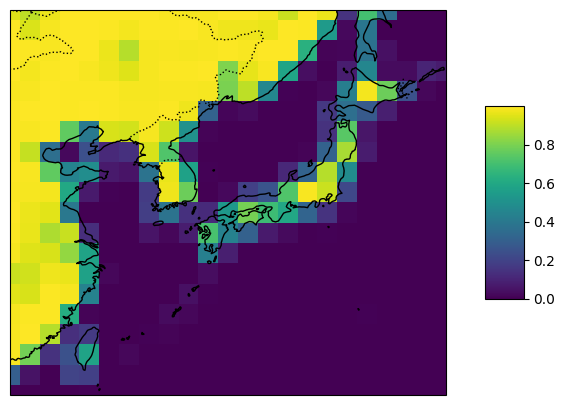

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 예제 NumPy 배열 생성
data = dataset

# 지도 생성 및 데이터 시각화
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# 지도에 기본 레이어 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# NumPy 배열을 지도 위에 표시 (임의의 위경도 범위에 맞게 조정)
lons = np.linspace(lon_min, lon_max, data.shape[1])
lats = np.linspace(lat_min, lat_max, data.shape[0])
Lons, Lats = np.meshgrid(lons, lats)
mesh = ax.pcolormesh(Lons, Lats, data, transform=ccrs.PlateCarree())

plt.colorbar(mesh, ax=ax, shrink=0.5, aspect=5)

plt.show()

In [27]:
import torch

def get_tgt_mask(var_len, tgt_time_len) -> torch.tensor:
        matrix = torch.zeros(var_len * tgt_time_len, var_len * tgt_time_len)

        for i in range(tgt_time_len):
            for j in range(var_len):
                inf_idx = min(((i)*var_len), var_len * tgt_time_len)
                matrix[:(i*var_len), inf_idx:] = float('-inf')
        return matrix


print(get_tgt_mask(3, 5))

tensor([[0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,